In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
metadata_species_df = pd.read_csv('taxonomy_species_metadata_biomass_merged.csv')
metadata_species_df['Stems'].fillna(0, inplace = True)
metadata_species_df['Shoots'].fillna(0, inplace = True)
metadata_species_df['Leaves'].fillna(0, inplace = True)
metadata_species_df['Grain 0% MC'].fillna(0, inplace = True)
metadata_species_df['Total biomass'] = metadata_species_df[['Stems', 'Shoots', 'Leaves', 'Grain 0% MC']].sum(axis = 1)

metadata_species_df['Soil temp'] = metadata_species_df['Sample date']
temps = [82.8, 78.1, 87.3, 77.4, 69.6]

replace_dict = dict(zip(set(metadata_species_df['Sample date']), temps))

metadata_species_df['Soil temp'] = metadata_species_df['Soil temp'].replace(replace_dict)

# Convert the dates from string to datetime
metadata_species_df['Sample date'] = pd.to_datetime(metadata_species_df['Sample date'])

# Find the earliest date
earliest_date = metadata_species_df['Sample date'].min()

# Calculate the number of days elapsed since the earliest date
metadata_species_df['Days Elapsed'] = (metadata_species_df['Sample date'] - earliest_date).dt.days

metadata_species_df.head()

,Unnamed: 0,Sample date,Sample ID,Plot,ID,Nitrogen,Water,Block,Direction,Barcode,...,Paraglomus brasilianum,Paraglomus laccatum,Redeckera fulvum,Scutellospora nodosa,Scutellospora pellucida,Scutellospora projecturata,Scutellospora spinosissima,Total biomass,Soil temp,Days Elapsed
0,barcode53B,2021-06-15,2N,2N,111.0,Low,High,1,N,53.0,...,0.000000,0.00000,0.000000,0.0,0.000000,52.007834,0.0,3.56,82.8,0
1,barcode65B,2021-06-15,2S,2S,111.0,Low,High,1,S,65.0,...,0.000000,0.00000,13.179038,0.0,24.524424,45.840968,0.0,3.56,82.8,0
2,barcode72B,2021-06-15,23S,23S,211.0,Low,High,2,S,72.0,...,38.251551,43.59947,0.000000,0.0,26.747810,0.000000,0.0,2.65,82.8,0
3,barcode81B,2021-06-15,23N,23N,211.0,Low,High,2,N,81.0,...,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,2.65,82.8,0
4,barcode55B,2021-06-15,32N,32N,311.0,Low,High,3,N,55.0,...,31.590360,38.35696,19.312906,0.0,29.028538,22.754466,0.0,2.11,82.8,0


In [3]:
# Select columns to be normalized
amf_species = ['Acaulospora sp.', 'Ambispora fennica',
       'Ambispora leptoticha', 'Archaeospora trappei',
       'Claroideoglomus lamellosum', 'Diversispora epigaea',
       'Diversispora spurca', 'Diversispora trimurales',
       'Entrophospora baltica', 'Geosiphon pyriformis',
       'Glomus Afrothismia foertheriana symbiont',
       'Glomus Arachnitis uniflora symbiont',
       'Glomus Burmannia hexaptera symbiont',
       'Glomus Voyriella parviflora symbiont type 1', 'Glomus caledonium',
       'Glomus clarum', 'Glomus coronatum', 'Glomus manihotis',
       'Glomus mosseae', 'Glomus proliferum', 'Glomus sp. 1',
       'Glomus sp. 2', 'Glomus sp. 3', 'Glomus sp. 4',
       'Pacispora scintillans', 'Paraglomus brasilianum',
       'Paraglomus laccatum', 'Redeckera fulvum', 'Scutellospora nodosa',
       'Scutellospora pellucida', 'Scutellospora projecturata',
       'Scutellospora spinosissima'
]

# Calculate the sum for each row
total_counts = metadata_species_df[amf_species].sum(axis=1)

# Divide each count by the total count and multiply by a constant (e.g., 1e6)
scaling_factor = 100
normalized_counts = metadata_species_df[amf_species].divide(total_counts, axis=0) * scaling_factor

# Replace the original columns with the normalized values
metadata_species_df[amf_species] = normalized_counts

In [4]:
[x* 1.12085 for x in set(metadata_species_df['N trt target'])]

[224.17, 22.416999999999998, 274.60825]

# Random forests predicting plant biomass

In [6]:
# Define the features and targets

features = amf_species + ['GWC', 'kg NH4-N / ha', 'kg NO3-N / ha', 'N trt target', 'Water trt target', 'Days Elapsed', 'Soil temp']
targets = ["Grain 0% MC", "Leaves"]

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in random forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [10, 20, 30, None],   # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
}

# Initialize the results dictionary
biomass_results = {}

# Subset the data for low Nitrogen and low Water treatments
# df = df[(metadata_species_df["Nitrogen"] == "Low") & (metadata_species_df["Water"] == "Low")]
# df = df[df['Sample date'] == '2021-09-23']

# Subset the data for last date
# df = metadata_species_df[metadata_species_df['Sample date'] == '2021-09-23']

df = metadata_species_df.copy()

# Perform a Random Forest regression for each target
for target in targets:
    # Remove NaN columns
    df = metadata_species_df[metadata_species_df[target] > 0]
    
    X = df[features]
    y = df[target]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Random Forest regressor
    rf = RandomForestRegressor(random_state=42)

    # Initialize the grid search
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = grid_search.best_params_

    # Perform the Random Forest regression with the best parameters
    rf_best = RandomForestRegressor(**best_params, random_state=42)
    rf_best.fit(X_train, y_train)

    # Predict the target for the testing set
    y_pred = rf_best.predict(X_test)

    # Calculate the metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
    print(f"R-squared: {r2}")

    # Get the feature importances
    importances = rf_best.feature_importances_

    # Store the results
    biomass_results[target] = {
        'r2': r2,
        'feature_importances': dict(zip(features, importances)),
        'best_params': best_params,
        'model': rf_best,
        'X_train': X_train,
        'X_test': X_test
    }

# Print the results
for target, result in biomass_results.items():
    print(f"Target: {target}")
    print(f"R^2 score: {result['r2']}")
    print(f"Feature importances: {result['feature_importances']}")
    print(f"Best parameters: {result['best_params']}")
    print("\n")

Mean Absolute Error (MAE): 108.78955023025178
Mean Squared Error (MSE): 20921.786548554785
Root Mean Squared Error (RMSE): 144.64365367535066
Mean Absolute Percentage Error (MAPE): 29.149358975720368%
R-squared: 0.3468274333263922
Mean Absolute Error (MAE): 15.191000000000003
Mean Squared Error (MSE): 351.1225900000002
Root Mean Squared Error (RMSE): 18.738265394640994
Mean Absolute Percentage Error (MAPE): 10.775429556017802%
R-squared: 0.3501219900423843
Target: Grain 0% MC
R^2 score: 0.3468274333263922
Feature importances: {'Acaulospora sp.': 0.08407770768357192, 'Ambispora fennica': 0.0, 'Ambispora leptoticha': 0.0024781842721137855, 'Archaeospora trappei': 0.06409992008771587, 'Claroideoglomus lamellosum': 0.0, 'Diversispora epigaea': 0.0, 'Diversispora spurca': 0.07843135934255038, 'Diversispora trimurales': 0.0, 'Entrophospora baltica': 0.0, 'Geosiphon pyriformis': 0.0, 'Glomus Afrothismia foertheriana symbiont': 0.055497535166909785, 'Glomus Arachnitis uniflora symbiont': 0.015

In [30]:
feature_importances = biomass_results["Grain 0% MC"]['feature_importances']
r2 = biomass_results["Grain 0% MC"]['r2']
total_variation_explained = sum(feature_importances[species] for species in amf_species)
print(f"Total variation explained by all species: {total_variation_explained}")
print(f"Total yield explained by all species: {total_variation_explained*r2}")

Total variation explained by the given species: 0.5333291350803018
Total yield explained by the given species: 0.1849731750380858


In [96]:
feature_importances = biomass_results["Leaves"]['feature_importances']
r2 = biomass_results["Leaves"]['r2']
total_variation_explained = sum(feature_importances[species] for species in amf_species)
print(f"Total variation explained by all species: {total_variation_explained}")
print(f"Total yield explained by all species: {total_variation_explained*r2}")

Total variation explained by all species: 0.6116344237982767
Total yield explained by all species: 0.2141466616386797


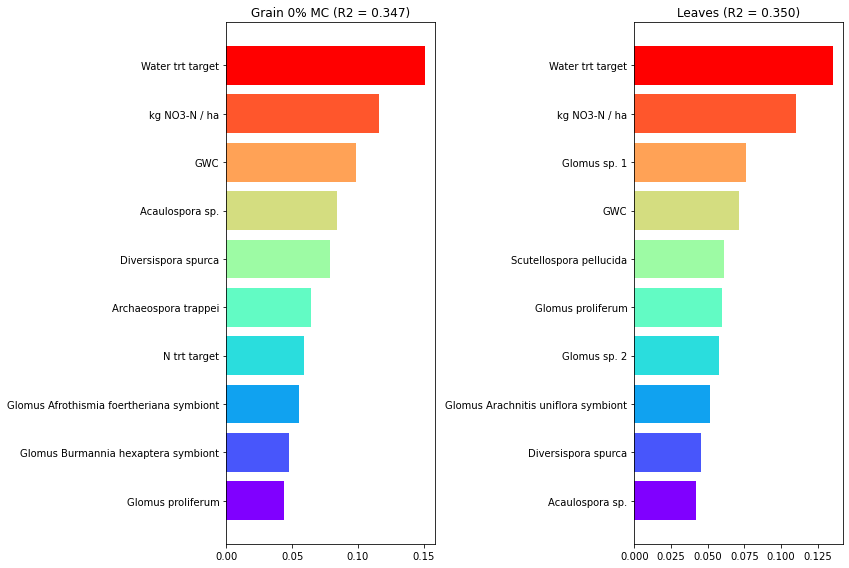

In [10]:
# Create color map
cmap = plt.cm.rainbow(np.linspace(0, 1, 10))

# Plot each target
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

for i, target in enumerate(targets):

    # Get data
    importances = biomass_results[target]['feature_importances']
    r2 = biomass_results[target]['r2']

    # Sort importances
    sorted_import = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:10]

    # Extract names and values
    names = [x[0] for x in sorted_import][::-1]
    values = [x[1] for x in sorted_import][::-1]

    # Plot bar chart
    ax = axs[i] # No need for a two-dimensional index
    ax.barh(names, values, color=cmap)

    # Set titles and axis
    title = f"{target} (R2 = {r2:.3f})"
    ax.set_title(title)

# Layout and show
fig.tight_layout()
plt.savefig('../../Fungal manuscript/Figures/yield_leaves_rf_importances.jpg', bbox_inches='tight', dpi=300)

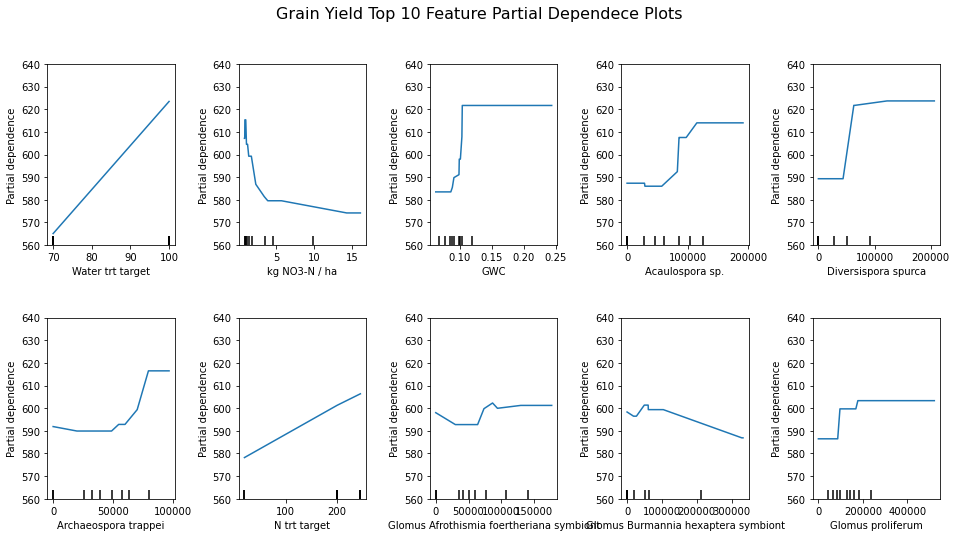

In [14]:
# Create 2x5 subplots grid
fig, axs = plt.subplots(2, 5, figsize=(16, 8), 
                        gridspec_kw={'wspace': 0.5, 'hspace': 0.4})


importances = biomass_results['Grain 0% MC']['feature_importances']

# Get the items as (name, importance) tuples
items = importances.items() 

# Sort by importance value in descending order 
sorted_items = sorted(items, key=lambda x: x[1], reverse=True)

# Get just the top 10 features
top_10 = sorted_items[:10] 

# Extract just the names
top_10_names = [item[0] for item in top_10]

# Plot each PDP on its own subplot axis
for i, feature in enumerate(top_10_names):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    
    pdp = plot_partial_dependence(
        biomass_results['Grain 0% MC']['model'], biomass_results['Grain 0% MC']['X_train'], features=[feature], ax=ax
    )
    plt.ylim(560, 640)


# Figure title  
fig.suptitle("Grain Yield Top 10 Feature Partial Dependece Plots", fontsize=16)
plt.savefig('../../Fungal manuscript/Figures/yield_feature_pdps.jpg', bbox_inches='tight', dpi=300)

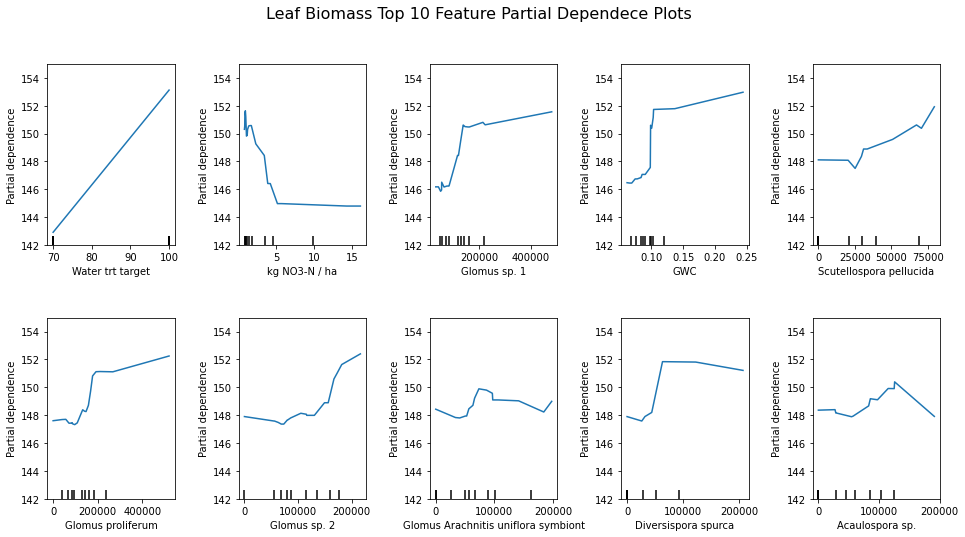

In [19]:
# Create 2x5 subplots grid
fig, axs = plt.subplots(2, 5, figsize=(16, 8), 
                        gridspec_kw={'wspace': 0.5, 'hspace': 0.4})


importances = biomass_results['Leaves']['feature_importances']

# Get the items as (name, importance) tuples
items = importances.items() 

# Sort by importance value in descending order 
sorted_items = sorted(items, key=lambda x: x[1], reverse=True)

# Get just the top 10 features
top_10 = sorted_items[:10] 

# Extract just the names
top_10_names = [item[0] for item in top_10]

# Plot each PDP on its own subplot axis
for i, feature in enumerate(top_10_names):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    
    pdp = plot_partial_dependence(
        biomass_results['Leaves']['model'], biomass_results['Leaves']['X_train'], features=[feature], ax=ax
    )
    plt.ylim(142, 155)

# Figure title  
fig.suptitle("Leaf Biomass Top 10 Feature Partial Dependece Plots", fontsize=16)
plt.savefig('../../Fungal manuscript/Figures/leaves_feature_pdps.jpg', bbox_inches='tight', dpi=300)

# Random forest predicting AM fungal species

In [34]:
# # Define the predictor variables
# predictors = ['N trt target', 'Water trt target', 'Block', 'Days Elapsed', 'GWC', 'Stems', 'Leaves', 'Total biomass',
#               'Shoots', 'Grain 0% MC', 'kg NH4-N / ha', 'kg NO3-N / ha', 'Soil temp']

# X = metadata_species_df[predictors]

# # Define the species
# species_list = ['Glomus Arachnitis uniflora symbiont','Glomus proliferum',
#           'Glomus sp. 3','Acaulospora sp.', 'Ambispora fennica', 'Ambispora leptoticha', 'Archaeospora trappei', 'Claroideoglomus lamellosum',
#            'Diversispora epigaea', 'Diversispora spurca', 'Diversispora trimurales', 'Entrophospora baltica',
#            'Geosiphon pyriformis', 'Glomus Afrothismia foertheriana symbiont', 'Glomus Burmannia hexaptera symbiont', 
#         'Glomus Voyriella parviflora symbiont type 1', 'Glomus caledonium',
#            'Glomus clarum', 'Glomus coronatum', 'Glomus manihotis', 'Glomus mosseae', 'Glomus sp. 1', 'Glomus sp. 2', 
#         'Glomus sp. 4', 'Pacispora scintillans',
#            'Paraglomus brasilianum', 'Paraglomus laccatum', 'Redeckera fulvum', 'Scutellospora nodosa',
#            'Scutellospora pellucida', 'Scutellospora projecturata', 'Scutellospora spinosissima']

# # GridSearchCV parameters
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Number of trees in random forest
#     'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
#     'max_depth': [3, 5, 10, 15, 20, None],   # Maximum number of levels in tree
#     'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
#     'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
# }

# results = {}

# # Loop through species and run a random forest for each
# for species in species_list:
#     y = metadata_species_df[species]
#     y = y.fillna(0)

#     # Split the data into training and testing data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
#     # Create a Random Forest Regressor
#     rf = RandomForestRegressor(random_state = 42)
      
#     CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
#     CV_rf.fit(X_train, y_train)

#     # Train the model using the best parameters
#     model = RandomForestRegressor(n_estimators=CV_rf.best_params_['n_estimators'],
#                                   max_features=CV_rf.best_params_['max_features'],
#                                   max_depth=CV_rf.best_params_['max_depth'],
#                                   min_samples_split=CV_rf.best_params_['min_samples_split'],
#                                   min_samples_leaf=CV_rf.best_params_['min_samples_leaf'],
#                                   random_state=42)
#     model.fit(X_train, y_train)

#     # Predict on the test set
#     y_pred = model.predict(X_test)

#     # Calculate R2 and MSE
#     r2 = r2_score(y_test, y_pred)
#     mse = mean_squared_error(y_test, y_pred)
    
#     # Get feature importances
#     importances = dict(zip(predictors, model.feature_importances_))

#     # Store the results in the results dictionary
#     species_results = {'R2': r2, 
#                        'MSE': mse, 
#                        'Feature importances': importances,
#                        'Best Parameters': CV_rf.best_params_,
#                        'model': model,
#                        'X_train': X_train
#                       }
    
#     results[species] = species_results

#     print(f"Species: {species}")
#     print(f"R2: {r2}")
#     print(f"MSE: {mse}")
#     print(f"Feature Importances: {importances}")
#     print("----")

Species: Glomus Arachnitis uniflora symbiont
R2: -0.1486537396882437
MSE: 4956200768.753091
Feature Importances: {'N trt target': 0.01568072236626166, 'Water trt target': 0.004105887600889655, 'Block': 0.09570690356428502, 'Days Elapsed': 0.0072405816887767096, 'GWC': 0.20263739037277737, 'Stems': 0.0882137851853183, 'Leaves': 0.06221674801830718, 'Total biomass': 0.0861060180248741, 'Shoots': 0.018372170462490033, 'Grain 0% MC': 0.003965034084296924, 'kg NH4-N / ha': 0.05004556956740615, 'kg NO3-N / ha': 0.3417029194311679, 'Soil temp': 0.02400626963314887}
----
Species: Glomus proliferum
R2: 0.14715445881749378
MSE: 11740338161.414024
Feature Importances: {'N trt target': 0.052375056318226657, 'Water trt target': 0.023476923321317802, 'Block': 0.029468685929943356, 'Days Elapsed': 0.039559466977812784, 'GWC': 0.28052950760641693, 'Stems': 0.05337993098890632, 'Leaves': 0.036435734232118336, 'Total biomass': 0.09913649805455721, 'Shoots': 0.07072684441644023, 'Grain 0% MC': 0.03300277

Species: Glomus Voyriella parviflora symbiont type 1
R2: -0.07678836408172685
MSE: 1074384291.3407524
Feature Importances: {'N trt target': 0.04876229525314343, 'Water trt target': 0.034194617137113054, 'Block': 0.02888384953546956, 'Days Elapsed': 0.02422059097628767, 'GWC': 0.09360195769733444, 'Stems': 0.1378962289307303, 'Leaves': 0.06535395353735475, 'Total biomass': 0.15156212559985557, 'Shoots': 0.027690764095824553, 'Grain 0% MC': 0.08058415963544278, 'kg NH4-N / ha': 0.14065290387810997, 'kg NO3-N / ha': 0.12811697227755467, 'Soil temp': 0.03847958144577912}
----
Species: Glomus caledonium
R2: -0.5297602906343304
MSE: 43810640.148119226
Feature Importances: {'N trt target': 0.03580713637795629, 'Water trt target': 0.008781015197241454, 'Block': 0.043592791448474236, 'Days Elapsed': 0.04398707632859796, 'GWC': 0.1720627226364291, 'Stems': 0.15973289360420734, 'Leaves': 0.0012919711911355727, 'Total biomass': 0.12333971178314776, 'Shoots': 0.048712127228895806, 'Grain 0% MC': 0.

Species: Scutellospora projecturata
R2: -0.05848593783980549
MSE: 1962089391.989817
Feature Importances: {'N trt target': 0.04964117699545684, 'Water trt target': 0.007954529307019382, 'Block': 0.05239527284321486, 'Days Elapsed': 0.04885643580954785, 'GWC': 0.1681254466810327, 'Stems': 0.061878097951421095, 'Leaves': 0.024674193503488966, 'Total biomass': 0.13662286357930767, 'Shoots': 0.05218431575474676, 'Grain 0% MC': 0.008898467289142063, 'kg NH4-N / ha': 0.1043395003943943, 'kg NO3-N / ha': 0.2071338517558855, 'Soil temp': 0.07729584813534188}
----
Species: Scutellospora spinosissima
R2: 0.0
MSE: 1823291.019527968
Feature Importances: {'N trt target': 0.06210569271199294, 'Water trt target': 0.044796230343153526, 'Block': 0.05795816175318883, 'Days Elapsed': 0.09785479791970407, 'GWC': 0.053330991264463605, 'Stems': 0.0, 'Leaves': 0.0, 'Total biomass': 0.12595161002004895, 'Shoots': 0.06551456594398707, 'Grain 0% MC': 0.0, 'kg NH4-N / ha': 0.15256123182472578, 'kg NO3-N / ha': 0.

In [65]:
# Extract best parameters for each species
best_params = {species: result['Best Parameters'] for species, result in results.items()}

# Save to JSON file
with open('AM_species_best_params.json', 'w') as file:
    json.dump(best_params, file)

In [74]:
# Load best parameters from JSON file
with open('AM_species_best_params.json', 'r') as file:
    best_params = json.load(file)

In [73]:
best_params

{'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

In [89]:
# Define the predictor variables
predictors = ['N trt target', 'Water trt target', 'Block', 'Days Elapsed', 'GWC', 'Stems', 'Leaves', 'Total biomass',
              'Shoots', 'Grain 0% MC', 'kg NH4-N / ha', 'kg NO3-N / ha', 'Soil temp']

X = metadata_species_df[predictors]

# Loop through species and run a random forest for each
for species in species_list:
    y = metadata_species_df[species]
    y = y.fillna(0)

    # Split the data into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create a Random Forest Regressor
    rf = RandomForestRegressor(random_state = 42)
    
    # Train the model using the best parameters
    model = RandomForestRegressor(n_estimators=best_params[species]['n_estimators'],
                                  max_features=best_params[species]['max_features'],
                                  max_depth=best_params[species]['max_depth'],
                                  min_samples_split=best_params[species]['min_samples_split'],
                                  min_samples_leaf=best_params[species]['min_samples_leaf'],
                                  random_state=42)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate R2 and MSE
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Get feature importances
    importances = dict(zip(predictors, model.feature_importances_))

    # Store the results in the results dictionary
    species_results = {'R2': r2, 
                       'MSE': mse, 
                       'Feature importances': importances,
                       'Best Parameters': CV_rf.best_params_,
                       'model': model,
                       'X_train': X_train
                      }
    
    results[species] = species_results

In [95]:
# 'Glomus proliferum',
#           'Glomus sp. 3', 'Diversispora spurca'
results['Diversispora spurca']

{'R2': 0.1311294664167142,
 'MSE': 64.49114385198217,
 'Feature importances': {'N trt target': 0.13036885984558233,
  'Water trt target': 0.025110306828447396,
  'Block': 0.0377678175585272,
  'Days Elapsed': 0.04236011268291368,
  'GWC': 0.24608401175090236,
  'Stems': 0.06133763325082801,
  'Leaves': 0.038725518617761974,
  'Total biomass': 0.12119329780655587,
  'Shoots': 0.04892574404354441,
  'Grain 0% MC': 0.051080750089208884,
  'kg NH4-N / ha': 0.07109959532350675,
  'kg NO3-N / ha': 0.10393689831115555,
  'Soil temp': 0.02200945389106554},
 'Best Parameters': {'max_depth': 3,
  'max_features': 'auto',
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 100},
 'model': RandomForestRegressor(max_depth=3, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, random_state=42),
 'X_train':      N trt target  Water trt target  Block  Days Elapsed       GWC   Stems  \
 159         200.0              70.0      2           100  0.085781

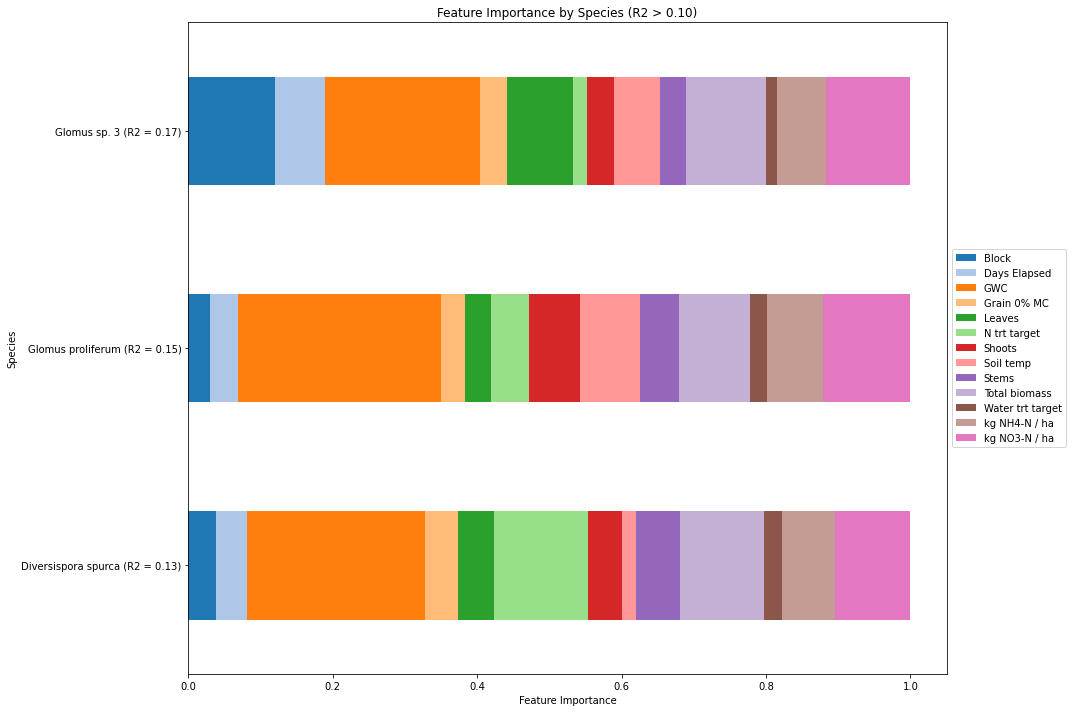

In [84]:
# Filter results to include only those with R2 > 0.2
filtered_results = {k: v for k, v in results.items() if v['R2'] > 0.10}

# Create a dataframe for feature importances
feature_importance_df = pd.DataFrame()

for species, values in filtered_results.items():
    temp_df = pd.DataFrame(list(values['Feature importances'].items()), columns=['Feature', 'Importance'])
    temp_df['Species'] = f"{species} (R2 = {values['R2']:.2f})"
    feature_importance_df = feature_importance_df.append(temp_df, ignore_index=True)

# Pivot the dataframe for the stacked bar plot
pivot_df = feature_importance_df.pivot(index='Species', columns='Feature', values='Importance')
pivot_df = pivot_df.fillna(0)  # Fill any NaN values with 0

# Define the color palette
palette = sns.color_palette("tab20", len(pivot_df.columns))

# Create the stacked bar plot with increased width
ax = pivot_df.plot(kind='barh', stacked=True, figsize=(15, 10), color=palette)

# Move the legend outside of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Feature Importance')
plt.title('Feature Importance by Species (R2 > 0.10)')
plt.tight_layout()
plt.savefig('../../Fungal manuscript/Figures/AMF_species_feature_importances.jpg', bbox_inches = 'tight', dpi = 300)

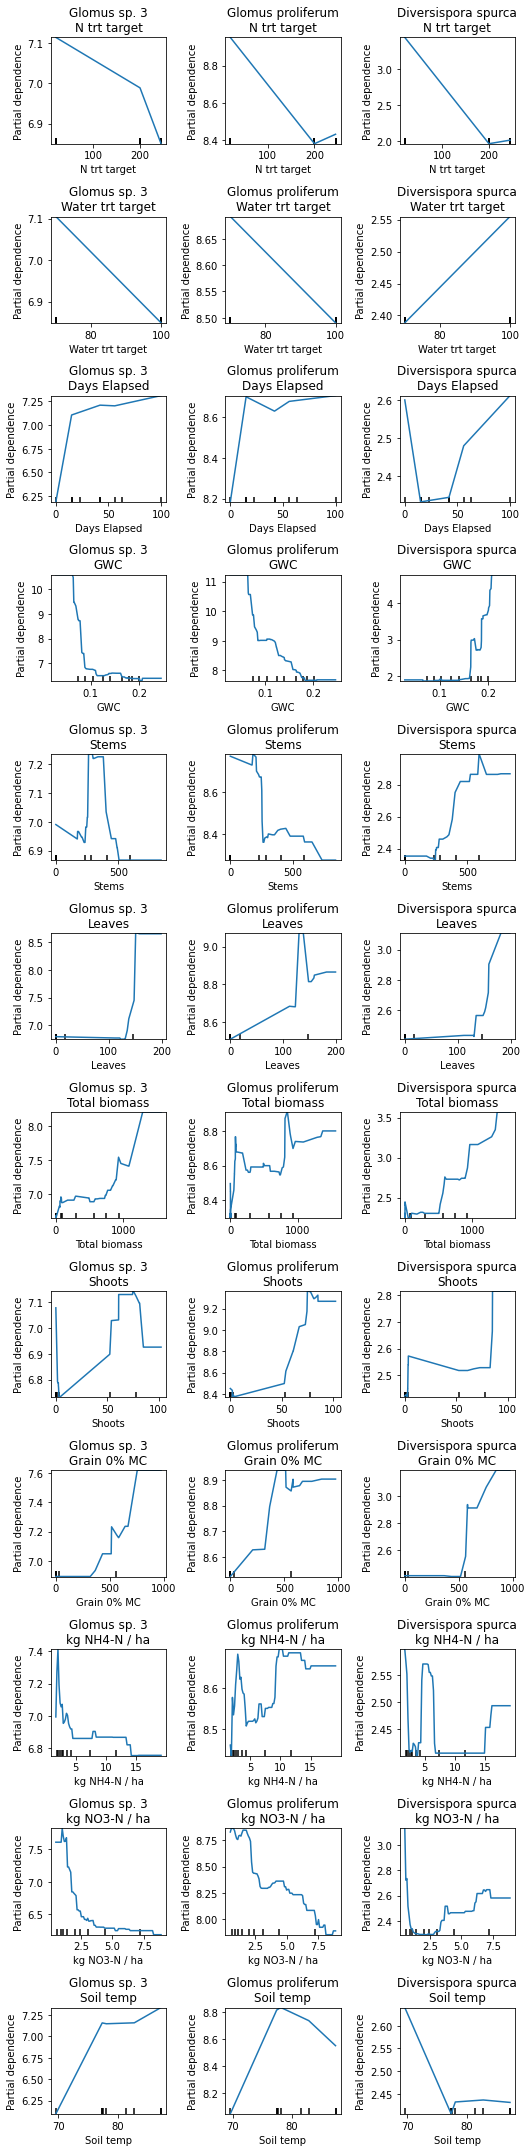

In [93]:
species_list = ['Glomus sp. 3', 'Glomus proliferum', 'Diversispora spurca']
predictors = ['N trt target', 'Water trt target', 'Days Elapsed', 'GWC', 'Stems', 'Leaves', 'Total biomass',
              'Shoots', 'Grain 0% MC', 'kg NH4-N / ha', 'kg NO3-N / ha', 'Soil temp']

n_features = len(predictors)
n_species = len(species_list)

# Create subplots with 2 columns and as many rows as there are features
fig, axs = plt.subplots(nrows=n_features, ncols=n_species, figsize=(7.5, 2.5*n_features), sharex='col')

# Remove gaps between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.3)

for i, predictor in enumerate(predictors):
    for j, species in enumerate(species_list):
        plot_partial_dependence(results[species]['model'], results[species]['X_train'], [predictor], ax=axs[i, j])
        axs[i, j].set_title(f"{species}\n{predictor}")
        
plt.tight_layout()
plt.savefig('../../Fungal manuscript/Figures/AMF_species_PDP.jpg', bbox_inches = 'tight', dpi = 300)

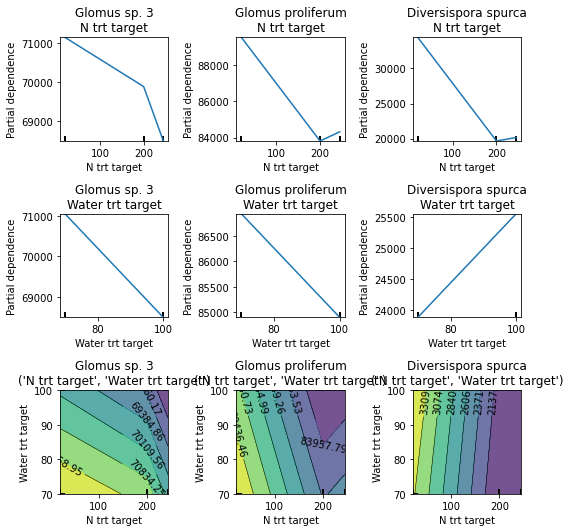

In [82]:
# Interaction effects
species_list = ['Glomus sp. 3', 'Glomus proliferum', 'Diversispora spurca']
predictors = ['N trt target', 'Water trt target', ('N trt target', 'Water trt target')]

n_features = len(predictors)
n_species = len(species_list)

# Create subplots with 2 columns and as many rows as there are features
fig, axs = plt.subplots(nrows=n_features, ncols=n_species, figsize=(7.5, 2.5*n_features), sharex='col')

# Remove gaps between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.3)

for i, predictor in enumerate(predictors):
    for j, species in enumerate(species_list):
        plot_partial_dependence(results[species]['model'], results[species]['X_train'], [predictor], ax=axs[i, j])
        axs[i, j].set_title(f"{species}\n{predictor}")
        
plt.tight_layout()
plt.savefig('../../Fungal manuscript/Figures/AMF_species_PDP_NxWater.jpg', bbox_inches = 'tight', dpi = 300)

In [79]:
import sklearn
print(sklearn.__version__)

0.23.2


# Figure 4

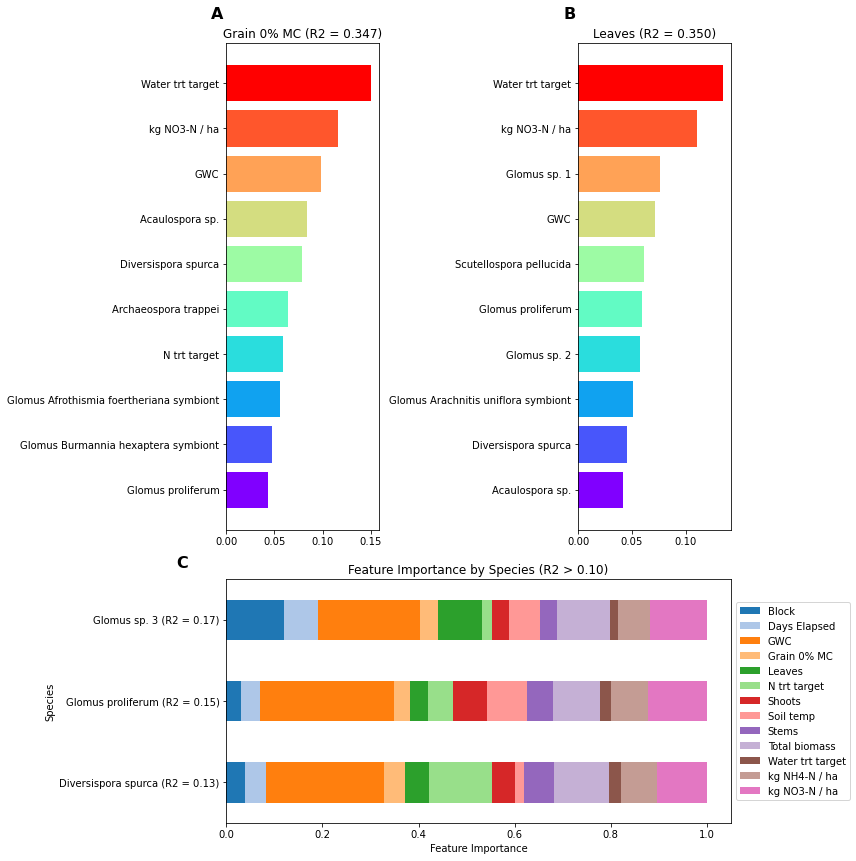

In [85]:
# Create a gridspec layout
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.5])

# Top two subplots (A, B)
for i, target in enumerate(targets):
    ax = plt.subplot(gs[0, i])

    # Get data
    importances = biomass_results[target]['feature_importances']
    r2 = biomass_results[target]['r2']

    # Sort importances
    sorted_import = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:10]

    # Extract names and values
    names = [x[0] for x in sorted_import][::-1]
    values = [x[1] for x in sorted_import][::-1]

    # Plot bar chart
    ax.barh(names, values, color=cmap)

    # Set titles and axis
    title = f"{target} (R2 = {r2:.3f})"
    ax.set_title(title)
    ax.text(-0.1, 1.05, chr(65 + i), transform=ax.transAxes, size=16, weight='bold')

# Bottom subplot (C) taking up both columns
ax = plt.subplot(gs[1, :])

# Define the color palette
palette = sns.color_palette("tab20", len(pivot_df.columns))

# Create the stacked bar plot with increased width
pivot_df.plot(kind='barh', stacked=True, ax=ax, color=palette)

# Move the legend outside of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Feature Importance')
ax.set_title('Feature Importance by Species (R2 > 0.10)')
ax.text(-0.1, 1.05, 'C', transform=ax.transAxes, size=16, weight='bold')

# Layout and show
plt.tight_layout()
plt.savefig('../../Fungal manuscript/Figures/Figure_4.jpg', bbox_inches = 'tight', dpi = 300)